In [1]:
model_str = "GINO"  # or "GNN"

import matplotlib.pyplot as plt
from data_loading import load_dataset
import torch
from deepcardio.losses import LpLoss
from predict import ModelInference
import numpy as np

DATA_DIR = r"/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data_processed"

if model_str == "GINO":
    from GINO.model import initialize_GINO_model
    model = initialize_GINO_model(n_fno_modes=4)
    folder_path=DATA_DIR + '/data_GINO.pt'
    from deepcardio.meshdata import BipartiteData
    dataset_format=BipartiteData
    save_dir = "./GINO/ckpt/ckpt_4/"
    dataprocessor_path = "./GINO/data_processor.pt"
    from GINO.gino_data_handling import single_case_handling

elif model_str == "GNN":
    from GNN.model import initialize_GNN_model
    model = initialize_GNN_model(size_hidden_layers=16)
    folder_path=DATA_DIR + '/data_GNN.pt'
    from torch_geometric.data import Data
    dataset_format=Data
    save_dir = "./GNN/ckpt/ckpt_64/"
    dataprocessor_path = "./GNN/data_processor.pt"
    from GNN.gnn_data_handling import single_case_handling

else:
    raise ValueError("Only 'GINO' or 'GNN' can be passed.")

dltrain, dltest, data_processor = load_dataset(
    model=model_str,
    folder_path=folder_path,
    train_batch_sizes=[1], test_batch_sizes=[1, 1],
    use_distributed=False, dataset_format=dataset_format,
    dataprocessor_dir='./')

model_inference = ModelInference(
    model=model,
    model_checkpoint_path=save_dir + 'best_model_snapshot_dict.pt',
    dataprocessor_path=dataprocessor_path,
    single_case_handling=single_case_handling)


l2loss = LpLoss(d=2, p=2, reductions='mean')

train_loss = l2loss
eval_losses={'l2': l2loss}

print(f"EPOCH: {model_inference.current_epoch}, LOSS: {model_inference.best_loss}")
model_inference.data_processor.training, model_inference.model.training

Total number of available samples: 35321
data_processor loaded from ./GINO/data_processor.pt.
Data got loaded in 264.90167980082333 seconds.
EPOCH: 1464, LOSS: 0.012492070734615612


(False, False)

In [2]:
from deepcardio.neuralop_core.utils import count_model_params
count_model_params(model)

965358

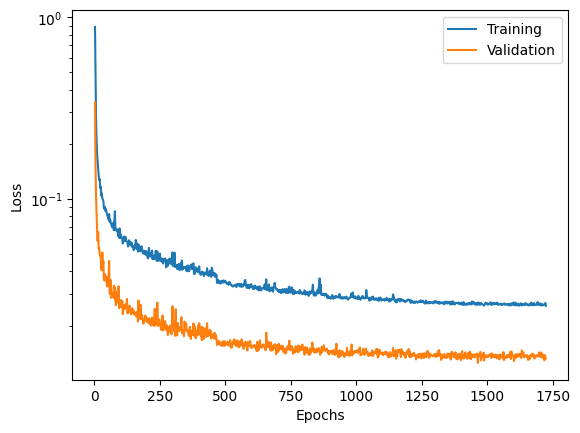

In [3]:
import json
from pathlib import Path
with open(Path(save_dir).joinpath('metrics_dict.json').as_posix(), 'r') as f:
    list_epoch_metrics = json.load(f)

epochs = []
training_losses = []
test_losses = []

for metrics_data in list_epoch_metrics:
    epochs.append(metrics_data['epoch'])
    training_losses.append(metrics_data['train_err'])
    test_losses.append(metrics_data['0_l2'])
    
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, test_losses, label="Validation")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

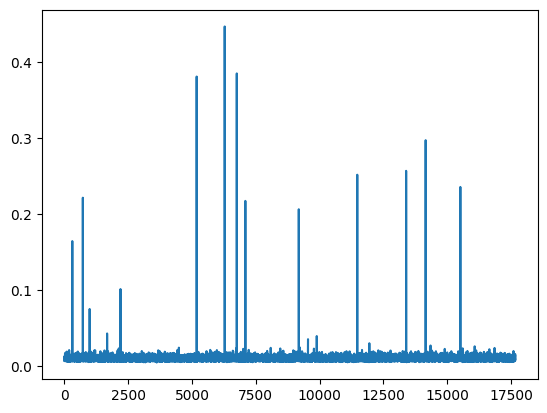

In [11]:
import pandas as pd
df = pd.DataFrame(columns=['case_id', 'loss'])
for i, sample in enumerate(dltrain[0]):
    # if sample['n_pacings'] == 1:
    #     continue
    model_inference.predict(sample)
    output = model_inference.output.to('cuda')
    train_loss = l2loss(output, **sample).item()
    torch.cuda.empty_cache()
    df.loc[i] = [int(sample['label'][0]), train_loss]

df.to_csv(f'train_losses.csv', index='case_id')

plt.plot(df['loss'])
plt.show()

In [12]:
print(torch.tensor(df['loss']).mean())
torch.topk(torch.tensor(df['loss']), k=20)

tensor(0.0104, dtype=torch.float64)


torch.return_types.topk(
values=tensor([0.4464, 0.3847, 0.3806, 0.2971, 0.2568, 0.2517, 0.2356, 0.2215, 0.2173,
        0.2063, 0.1645, 0.1015, 0.0754, 0.0432, 0.0398, 0.0357, 0.0304, 0.0274,
        0.0263, 0.0248], dtype=torch.float64),
indices=tensor([ 6283,  6756,  5185, 14153, 13389, 11475, 15512,   727,  7092,  9184,
          315,  2202,   994,  1678,  9888,  9546, 11948, 14344, 16073,  9230]))

In [15]:
# sample = dltrain[0].dataset[6283]
sample['label'], sample['n_pacings'], sample['y'].max(), l2loss(model_inference.predict(sample), **sample).item()

('3215', 1, tensor(69., device='cuda:0'), 0.00791389960795641)

In [16]:
meshfile = '/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data/mesh/case'
xdmffile = './GINO/results/xdmf/case'

model_inference.predict('/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data/mesh/case6283.vtk')
model_inference.case_ID = model_inference.case_ID[:-4]
model_inference.write_xdmf(
    mesh_directory=meshfile,
    xdmf_directory=xdmffile)

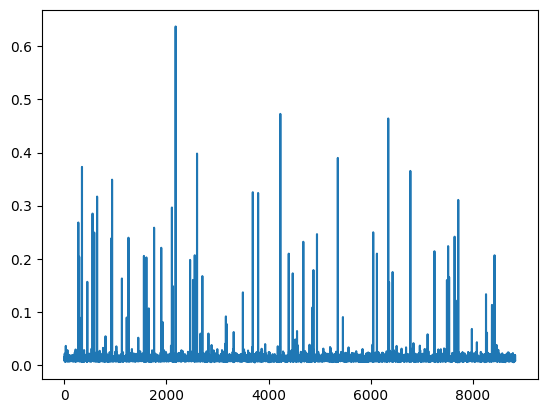

In [7]:
val_losses = []
for sample in dltest[0]:
    model_inference.predict(sample)
    output = model_inference.output.to('cuda')
    test_loss = l2loss(output, **sample).item()
    torch.cuda.empty_cache()
    val_losses.append(test_loss)
plt.plot(val_losses)
plt.show()


In [8]:
print(torch.tensor(val_losses).mean())
torch.topk(torch.tensor(val_losses), k=5)

tensor(0.0136)


torch.return_types.topk(
values=tensor([0.6370, 0.4726, 0.4640, 0.3980, 0.3898]),
indices=tensor([2181, 4231, 6344, 2600, 5357]))

In [23]:
test_losses = np.zeros((len(dltest[1]), 9))  # d_iso, n_pacings, 0.0, 0.01, 0.02, 0.05, 0.1, 0.2, refined

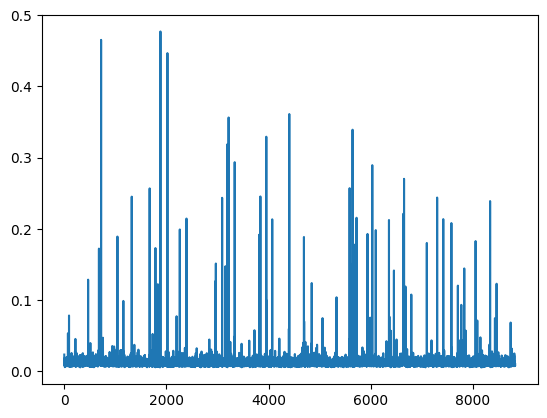

In [31]:

noise = 0.05
for i, sample in enumerate(dltest[1]):
    sample['input_geom'] += torch.randn_like(sample['input_geom']) * (noise * sample['input_geom'].std())
    f0 = sample['a'][:, :, 2:5]
    sample['a'][:, :, 2:5] += torch.randn_like(f0) * (noise * f0.std())
    output = model_inference.predict(sample)
    test_loss = l2loss(output, **sample).item()
    d_iso = sample['a'][:, 0, 1].mean().item()
    test_losses[i, 0] = d_iso
    test_losses[i, 1] = sample['n_pacings']
    test_losses[i, 2] = test_loss
    torch.cuda.empty_cache()
plt.plot(test_losses[:, 2])
plt.show()

In [25]:
print(torch.tensor(test_losses[:, 2]).mean())
torch.topk(torch.tensor(test_losses[:, 2]), k=20)

tensor(0.0135, dtype=torch.float64)


torch.return_types.topk(
values=tensor([0.4772, 0.4654, 0.4468, 0.3613, 0.3565, 0.3393, 0.3294, 0.3187, 0.2937,
        0.2895, 0.2704, 0.2572, 0.2569, 0.2456, 0.2453, 0.2441, 0.2437, 0.2391,
        0.2214, 0.2157], dtype=torch.float64),
indices=tensor([1883,  721, 2020, 4406, 3218, 5645, 3956, 3191, 3337, 6031, 6653, 5587,
        1672, 3840, 1321, 7301, 3091, 8338, 6640, 5723]))

In [32]:
np.save("/mnt/home/naghavis/Documents/Research/DeepCardioSim/cardiac_models/electrophysio/data/posttraining/test_GINO.npy", test_losses)

In [24]:
np.percentile(kir[:, 2], 99.5)

np.float64(0.12296574272215337)

In [22]:
sample = dltest[1].dataset[4406]
sample['label'], sample['n_pacings'], sample['y'].max(), l2loss(model_inference.predict(sample), **sample).item()

('33759', 2, tensor(112.), 0.36125800013542175)

In [23]:
meshfile = '/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data/mesh/case'
xdmffile = './GINO/results/xdmf/case'

model_inference.write_xdmf(
    mesh_directory=meshfile,
    xdmf_directory=xdmffile)

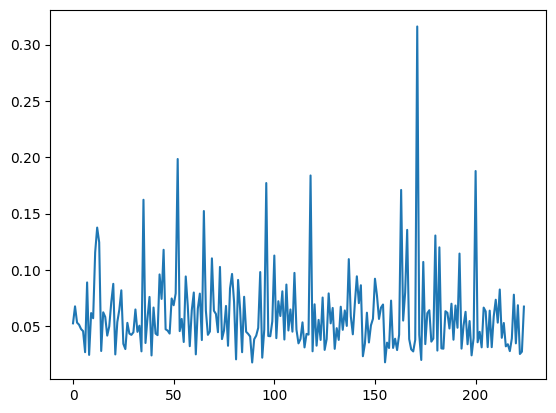

In [32]:
import glob
import os
folder_path = '/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data_realLV/YHC/mesh'
YHC_losses = []
vtk_files = []
vtk_files.extend(glob.glob(os.path.join(folder_path, '*.vtk')))

for i, file in enumerate(vtk_files):
    model_inference.predict(file)
    output = model_inference.output.to('cuda')
    model_inference.case_ID = model_inference.case_ID[:-4]
    interpolated_loss = l2loss(output, **model_inference.sample).item()
    torch.cuda.empty_cache()
    YHC_losses.append(interpolated_loss)
    
plt.plot(YHC_losses)
plt.show()

In [33]:
print(torch.tensor(YHC_losses).mean())
torch.topk(torch.tensor(YHC_losses), k=20)

tensor(0.0603)


torch.return_types.topk(
values=tensor([0.3161, 0.1984, 0.1877, 0.1838, 0.1771, 0.1709, 0.1622, 0.1522, 0.1375,
        0.1355, 0.1305, 0.1244, 0.1199, 0.1178, 0.1155, 0.1144, 0.1127, 0.1102,
        0.1095, 0.1070]),
indices=tensor([171,  52, 200, 118,  96, 163,  35,  65,  12, 166, 180,  13, 182,  45,
         11, 192, 100,  69, 137, 174]))

In [36]:
vtk_files[171]

'/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data_realLV/YHC/mesh/case219.vtk'

In [37]:
model_inference.predict(vtk_files[171])
model_inference.case_ID = model_inference.case_ID[:-4]
model_inference.write_xdmf(
    mesh_directory='/mnt/research/compbiolab/Ehsan/DeepCardioSim/cardiac_models/electrophysio/data_realLV/YHC/mesh/case',
    xdmf_directory='./GINO/results/xdmf/case')

In [6]:
model_inference.predict('/mnt/home/naghavis/Documents/Research/heArt/generate_EP_dataset/data/mesh/case177.vtk')
l2loss(model_inference.output, **model_inference.sample).item(), model_inference.case_ID

(0.2413378655910492, '177.vtk')

In [10]:
model_inference.case_ID = model_inference.case_ID[:-4]
model_inference.write_xdmf(
    mesh_directory='/mnt/home/naghavis/Documents/Research/heArt/generate_EP_dataset/data/mesh/case',
    xdmf_directory='/mnt/home/naghavis/Documents/Research/DeepCardioSim/real_geom_res/case'
)

In [9]:
len('_refinedinterp.vtk')

18

In [16]:
dltest[1].dataset[0]

BipartiteData(edge_index=[2, 16214], y=[4804, 1, 1], a=[4804, 1, 5], input_geom=[4804, 3], latent_queries=[1, 32, 32, 32, 3], label='7205', n_pacings=2, num_nodes=4804)

In [18]:
import glob
import os
folder_path = './data/interpolated'
interpolated_losses = []
vtk_files = []
vtk_files.extend(glob.glob(os.path.join(folder_path, '*.vtk')))

meshes = []
# for i, file in enumerate(vtk_files):
    # model_inference.predict(file)
    # output = model_inference.output.to('cuda')
    # model_inference.case_ID = model_inference.case_ID[:-4]
    # interpolated_loss = l2loss(output, **model_inference.sample).item()
    # torch.cuda.empty_cache()
    # interpolated_losses.append(interpolated_loss)
    
# plt.plot(interpolated_losses)
# plt.show()

d_iso_dev_1ploc = []
d_iso_dev_2ploc = []
for i, file in enumerate(vtk_files):
    model_inference.predict(file)
    for data in dltest[1]:
        if data['label'] == model_inference.sample['label'][:-18]:
            n_pacings = data['n_pacings']
            break
    d_iso = model_inference.sample['a'][:, 0, 1].cpu().numpy().mean()
    max_tact = model_inference.sample['y'].max().cpu().numpy()
    if n_pacings == 1:
        d_iso_dev_1ploc.append(d_iso)
    elif n_pacings == 2:
        d_iso_dev_2ploc.append(d_iso)
np.save('./data_posttraining/d_iso_interp_1ploc.npy', d_iso_dev_1ploc)
np.save('./data_posttraining/d_iso_interp_2ploc.npy', d_iso_dev_2ploc)

In [ ]:
print(torch.tensor(interpolated_losses).mean())
torch.topk(torch.tensor(interpolated_losses), k=5)

In [ ]:
np.save("./data_posttraining/interp_GINO.npy", interpolated_losses)

In [ ]:
torch.tensor(test_losses).mean()

In [ ]:
torch.topk(torch.tensor(test_losses), k=20)

In [6]:
# import pandas as pd

# df = pd.DataFrame(columns=['Loss', 'd_iso', 'n_pacings', 'max_tact'])
d_iso_dev_1ploc = []
d_iso_dev_2ploc = []
for sample in dltrain[0]:
    # loss = l2loss(model_inference.predict(sample), **sample).item()
    n_pacings = sample['n_pacings'].cpu().numpy()
    d_iso = sample['a'][:, 0, 1].cpu().numpy().mean()
    max_tact = sample['y'].max().cpu().numpy()
    if n_pacings == 1:
        d_iso_dev_1ploc.append(d_iso)
    elif n_pacings == 2:
        d_iso_dev_2ploc.append(d_iso)
    # df.loc[len(df)] = [loss, d_iso, n_pacings, max_tact]
np.save('./data_posttraining/d_iso_train_1ploc.npy', d_iso_dev_1ploc)
np.save('./data_posttraining/d_iso_train_2ploc.npy', d_iso_dev_2ploc)
# df.to_pickle('./data_posttraining/test_GINO_withoutnoise.pkl')

In [ ]:
i = -1
for sample in dltest[1]:
    i += 1
    if sample['n_pacings'] == 2 or sample['y'].max() < 120 or sample['y'].max() > 150:
        continue
    print(i, sample['label'], sample['n_pacings'], sample['y'].max(), l2loss(model_inference.predict(sample), **sample).item())

In [ ]:
# Inverse problem
import meshio
def optimization_function_wrapper(x):
    """
    This wraps the function for the inverse modeling
    optimization problem.

    Input:
    - x: a numpy array represents [D_iso, x_l, x_c]

    Output:
    - loss: The loss of the optimization problem, returned as a
    scalar numpy value
    """
    ploc_pmtr = [x[1], x[2], 1]
    geometry = meshio.read('./data/geometry' + sample['label'] + '.vtk')
    pmtr_coord = np.concatenate((
        geometry.point_data['x_l'],
        geometry.point_data['x_c'],
        geometry.point_data['x_t']), axis=1)

    min_loc = np.argmin(np.linalg.norm(pmtr_coord - np.array(ploc_pmtr), axis=1))
    ploc_xyz = geometry.points[min_loc].reshape((1, -1)) * 100


    output = model_inference.predict(sample, Diso=x[0], plocs=ploc_xyz, r=0.55)

    loss = l2loss(output, sample['y'])
    return loss.item()

from scipy.optimize import differential_evolution

bounds = [(0.1, 2.), (0.15, .8), (-3., 3.)]

result = differential_evolution(optimization_function_wrapper,
                                        bounds,
                                        seed=45,
                                        popsize=50,
                                        strategy='best1bin',
                                        maxiter=100,
                                        disp=True)

result.x

In [6]:
# Ground truth
0.12689291957489515
[0.3247652436498567, -2.853311347773299]

In [ ]:
# CRT Optimization
def optimization_function_wrapper(x):
    """
    This wraps the function for the inverse modeling
    optimization problem.

    Input:
    - x: a numpy array represents [x_l2, x_c2]

    Output:
    - loss: The loss of the optimization problem, returned as a
    scalar numpy value
    """
    plocs_pmtr = [[result.x[1], result.x[2], 1], [x[0], x[1], 1]]
    geometry = meshio.read('./data/geometry' + sample['label'] + '.vtk')
    pmtr_coord = np.concatenate((
        geometry.point_data['x_l'],
        geometry.point_data['x_c'],
        geometry.point_data['x_t']), axis=1)
    
    plocs_xyz = []
    for ploc_ in plocs_pmtr:
        min_loc = np.argmin(np.linalg.norm(pmtr_coord - np.array(ploc_), axis=1))
        ploc_xyz = geometry.points[min_loc] * 100
        plocs_xyz.append(ploc_xyz)

    plocs_xyz = np.array(plocs_xyz)


    output = model_inference.predict(sample, Diso=result.x[0], plocs=plocs_xyz, r=0.55)

    return output.max().item()

bounds = [(0.15, .8), (-3., 3.)]

result_CRT = differential_evolution(
    optimization_function_wrapper,bounds,
    seed=45,
    popsize=50,
    strategy='best1bin',
    maxiter=100,
    disp=True)

result_CRT.x

In [ ]:
result_CRT.fun

In [ ]:
plocs_xyz = []

plocs_pmtr = [[result.x[1], result.x[2], 1], [result_CRT.x[0], result_CRT.x[1], 1]]
geometry = meshio.read('./data/geometry' + sample['label'] + '.vtk')
pmtr_coord = np.concatenate((
    geometry.point_data['x_l'],
    geometry.point_data['x_c'],
    geometry.point_data['x_t']), axis=1)

for ploc_ in plocs_pmtr:
    min_loc = np.argmin(np.linalg.norm(pmtr_coord - np.array(ploc_), axis=1))
    ploc_xyz = geometry.points[min_loc] * 100
    plocs_xyz.append(ploc_xyz)

plocs_xyz = np.array(plocs_xyz)

plocs_xyz

In [ ]:
ploc_pmtr = [result.x[1], result.x[2], 1]
geometry = meshio.read('./data/geometry' + sample['label'] + '.vtk')
pmtr_coord = np.concatenate((
    geometry.point_data['x_l'],
    geometry.point_data['x_c'],
    geometry.point_data['x_t']), axis=1)

min_loc = np.argmin(np.linalg.norm(pmtr_coord - np.array(ploc_pmtr), axis=1))
ploc_xyz = geometry.points[min_loc].reshape((1, -1)) * 100
ploc_xyz

In [58]:
output = model_inference.predict(sample, Diso = result.x[0], plocs=plocs_xyz, r=0.55)

In [ ]:
output.max()

In [ ]:
i = 0
for sample in dltest[1]:
    if sample['label'] == ['35865']:
        print(i)
        break
    i+=1


In [ ]:
# 2701: 9709
# 3260: 36214
# 22: 26514 0.0108
# 37: 18362 0.0079

# 4170: 7963 0.0102

In [ ]:
sample = dltest[1].dataset[90]
sample['label'], sample['n_pacings'], sample['y'].max(), l2loss(model_inference.predict(sample), **sample).item()

In [ ]:
import meshio
def set_rand_pacingsites(sample, rand):
    np.random.seed(rand)
    x_l = np.random.uniform(0.15, 0.8)
    x_c = np.random.uniform(-3, 3)
    x_c_2 = np.random.uniform(-3, 3)
    plocs_pmtr = [[x_l, x_c, 1], [x_l, x_c_2, 1]]
    geometry = meshio.read('../data/geometry_case' + sample['label'] + '.vtk')
    pmtr_coord = np.concatenate((
        geometry.point_data['x_l'],
        geometry.point_data['x_c'],
        geometry.point_data['x_t']), axis=1)

    plocs_xyz = []
    for ploc_ in plocs_pmtr:
        min_loc = np.argmin(np.linalg.norm(pmtr_coord - np.array(ploc_), axis=1))
        ploc_xyz = geometry.points[min_loc] * 100
        plocs_xyz.append(ploc_xyz)

    plocs_xyz = np.array(plocs_xyz)

    new_sample = model_inference.set_pacingsite(sample, plocs_xyz, r = [.55, .55])
    del new_sample['y']
    return new_sample


In [ ]:
t_act_min = 200
t_act_max = 10
for i in range(1000):
    new_sample = set_rand_pacingsites(sample, 1000 + i)
    output = model_inference.predict(new_sample)
    if output.max() > t_act_max:
        if output.max() > 131:
            continue
        t_act_max = output.max()
        model_inference.write_xdmf(
            inp=sample,
            mesh_directory='./data/mesh/case',
            xdmf_directory='./GINO/results/xdmf/maxcase')
    if output.max() < t_act_min:
        t_act_min = output.max()
        model_inference.write_xdmf(
            inp=sample,
            mesh_directory='./data/mesh/case',
            xdmf_directory='./GINO/results/xdmf/mincase')
        
    